In [1]:
# Необходимо для корректной работы внешних .py файлов
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from helper import *
from plots import *
from timeit import default_timer as timer
import random
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from skopt.space import Integer, Real, Categorical
from skopt import BayesSearchCV
from scipy import stats as sp

In [3]:
# фиксируем состояние генератора псевдослучайных чисел. Это необходимо, чтобы результаты модели не менялись с каждым новым запуском 
SEED = 42 # можно указать любое число
np.random.seed(SEED)
random.seed(SEED)

In [4]:
df = pd.read_csv("data.csv")

## 1. Предобработка

In [5]:
df_preprocessed = df.copy()
# Удаляем полные дубликаты строк
df_preprocessed = df_preprocessed.drop_duplicates()
# Удаляем строки с отрицательными значениями таргета Billing Amount
df_preprocessed = df_preprocessed[df_preprocessed['Billing Amount'] >= 0]
df_preprocessed['Age'] = pd.to_numeric(df_preprocessed['Age'])
# Преобразуем даты в тип datetime
df_preprocessed['Date of Admission'] = pd.to_datetime(
    df_preprocessed['Date of Admission'], errors='coerce'
)
df_preprocessed['Discharge Date'] = pd.to_datetime(
    df_preprocessed['Discharge Date'], errors='coerce'
)
# Делаем числовые признаки из даты
df_preprocessed["Admission_Year"]      = df_preprocessed["Date of Admission"].dt.year
df_preprocessed["Admission_Month"]     = df_preprocessed["Date of Admission"].dt.month
df_preprocessed["Admission_DayOfWeek"] = df_preprocessed["Date of Admission"].dt.dayofweek  # 0=Пн

df_preprocessed["Discharge_Year"]      = df_preprocessed["Discharge Date"].dt.year
df_preprocessed["Discharge_Month"]     = df_preprocessed["Discharge Date"].dt.month
df_preprocessed["Discharge_DayOfWeek"] = df_preprocessed["Discharge Date"].dt.dayofweek  # 0=Пн

df_preprocessed['Length_of_stay'] = (
    df_preprocessed['Discharge Date'] - df_preprocessed['Date of Admission']
).dt.days.clip(lower=0)

# Исходную дату выбрасываем
df_preprocessed = df_preprocessed.drop(columns=["Date of Admission"])
df_preprocessed = df_preprocessed.drop(columns=["Discharge Date"])

# удаляем Hospital (тк он имеет 39876 уникальных значений, что очень много), номер комнаты, имя и доктора, тк они не несут какого-то значения
df_preprocessed = df_preprocessed.drop(columns=['Hospital', 'Room Number', "Name", "Doctor"])

In [6]:
X, y = divide_data(df_preprocessed, 'Billing Amount')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [7]:
bins = [0, 25, 40, 60, 120]
labels = [0, 1, 2 , 3]

X['Age'] = pd.cut(X['Age'], bins=bins, labels=labels, right=True)

In [8]:
categorical_cols = ['Gender', 'Blood Type', 'Medical Condition', 'Insurance Provider', 'Admission Type', 'Medication', 'Test Results']
numeric_cols = [c for c in X.columns if c not in categorical_cols]
category_orders = [
    ['Male', 'Female'], # gender
    ['A+', 'A-', 'B+', 'B-', 'AB+', 'AB-', 'O+', 'O-'], # Blood Type                         
    ['Arthritis', 'Diabetes', 'Hypertension', 'Obesity', 'Cancer', 'Asthma'], # Medical Condition    
    ['UnitedHealthcare', 'Cigna', 'Medicare', 'Blue Cross', 'Aetna'], # Insurance Provider        
    ['Urgent', 'Emergency', 'Elective'], # Admission Type
    ['Lipitor', 'Ibuprofen', 'Aspirin', 'Paracetamol', 'Penicillin'], # Medication
    ['Abnormal', 'Normal', 'Inconclusive'], # Test Results
]

preprocessor = Pipeline([ 
    # Кодирование категориальных признаков (зависит от завершения обоих этапов импутации)
    ('transformations', ColumnTransformer(
        transformers=[
            ('encoder',
             OrdinalEncoder(categories=category_orders),
             categorical_cols)
        ],
        remainder='passthrough',  # числовые колонки передаются без изменений
        verbose_feature_names_out=False
    ))
])
preprocessor.set_output(transform="pandas")

,steps,"[('transformations', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [9]:
base_model = ('RandomForestRegressor', RandomForestRegressor(random_state=SEED))

In [10]:
preprocessor.steps.append(base_model)
pipeline = preprocessor

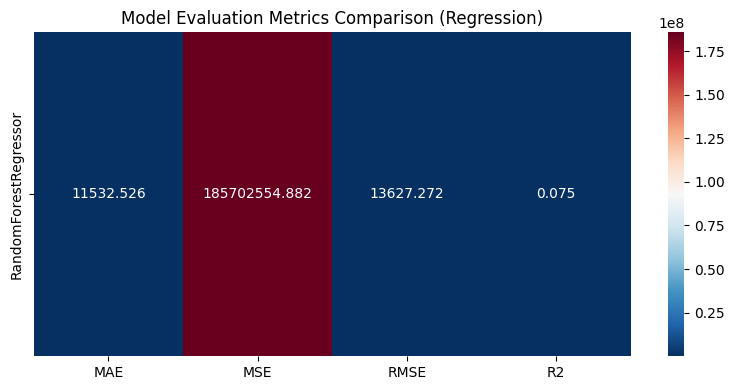

In [11]:
initial_metrics = train_evaluate_models(
    models=[('RandomForestRegressor', pipeline)],
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    seed=SEED
)

In [12]:
initial_metrics

,MAE,MSE,RMSE,R2
RandomForestRegressor,11532.526093,1.857026e+08,13627.272467,0.074845


## 2. Подбор гиперпараметров

In [13]:
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

### 2.1 Grid Search

In [14]:
param_grid = {
    # сколько деревьев в лесе
    "RandomForestRegressor__n_estimators": [200, 400, 600],

    # глубина деревьев
    "RandomForestRegressor__max_depth": [None, 5, 10, 20],

    # минимальное число объектов для разбиения и в листе
    "RandomForestRegressor__min_samples_split": [2, 5, 10],
    "RandomForestRegressor__min_samples_leaf": [1, 3, 5],

    # сколько признаков смотреть в каждом сплите
    "RandomForestRegressor__max_features": ["sqrt", 0.5],

    # бутстрэп или нет
    #"RandomForestRegressor__bootstrap": [True, False],
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=cv,
    n_jobs=-1,
    verbose=3
)

In [15]:
grid_search_start = timer()
grid_search.fit(X_train, y_train)
grid_search_end = timer()

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
66 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
23 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\theea\AppD

In [16]:
print(f"Total time: {grid_search_end - grid_search_start:.2f} seconds")

Total time: 2187.40 seconds


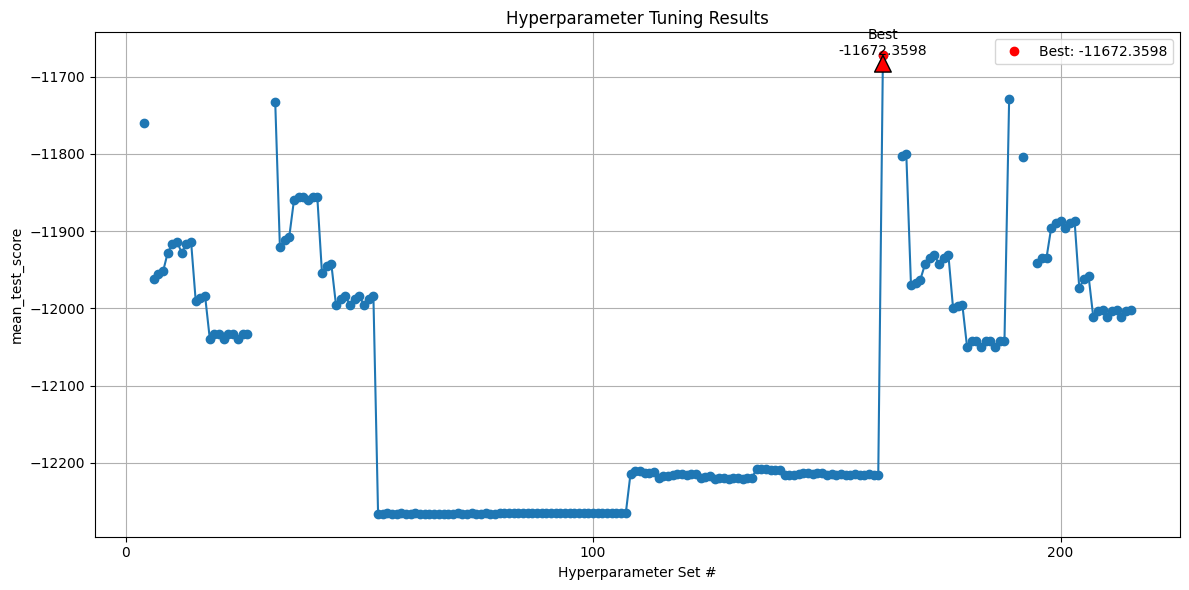

In [17]:
data = plot_hyperparam_search_results(grid_search.cv_results_, xtick_step=100)

In [18]:
grid_search.best_params_

{'RandomForestRegressor__max_depth': 20,
 'RandomForestRegressor__max_features': 'sqrt',
 'RandomForestRegressor__min_samples_leaf': 1,
 'RandomForestRegressor__min_samples_split': 2,
 'RandomForestRegressor__n_estimators': 200}

In [19]:
grid_search_best_model = grid_search.best_estimator_

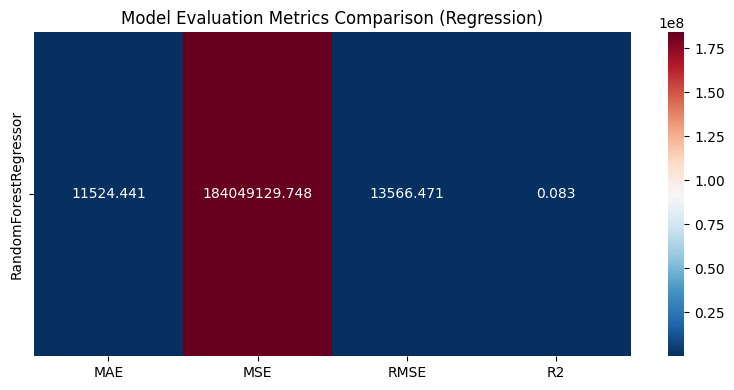

In [20]:
grid_search_metrics = train_evaluate_models(
    models=[('RandomForestRegressor', grid_search_best_model)],
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    seed=SEED
)

In [21]:
grid_search_metrics

,MAE,MSE,RMSE,R2
RandomForestRegressor,11524.441305,1.840491e+08,13566.470792,0.083082


(<Figure size 800x400 with 2 Axes>,
                             MAE       RMSE        R2
 RandomForestRegressor -8.084788 -60.801675  0.008237)

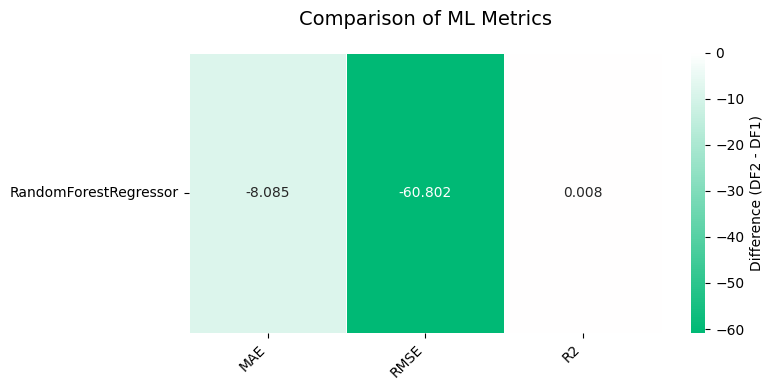

In [22]:
compare_metrics_heatmap(initial_metrics, grid_search_metrics)

### 2.2 Randomized search

In [45]:
param_dist = {
    # сколько деревьев
    "RandomForestRegressor__n_estimators": sp.randint(100, 600),

    # глубина деревьев (None = расти до упора)
    "RandomForestRegressor__max_depth": [None] + list(range(3, 16)),

    # минимальное число объектов для разбиения узла
    "RandomForestRegressor__min_samples_split": sp.randint(2, 10),

    # минимальное число объектов в листе
    "RandomForestRegressor__min_samples_leaf": sp.randint(1, 10),

    # доля признаков для выбора сплита
    "RandomForestRegressor__max_features": ["sqrt", "log2", 0.5, 1.0],

    # бутстрэп
    "RandomForestRegressor__bootstrap": [True, False], 
}

In [46]:
randomized_search = RandomizedSearchCV(
    random_state=SEED,
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=100,
    scoring='neg_mean_absolute_error',
    cv=cv,
    n_jobs=-1,
    verbose=3
)

In [47]:
randomized_search_start = timer()
randomized_search.fit(X_train, y_train)
randomized_search_end = timer()

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [48]:
print(f"Total time: {randomized_search_end - randomized_search_start:.2f} seconds")

Total time: 1431.46 seconds


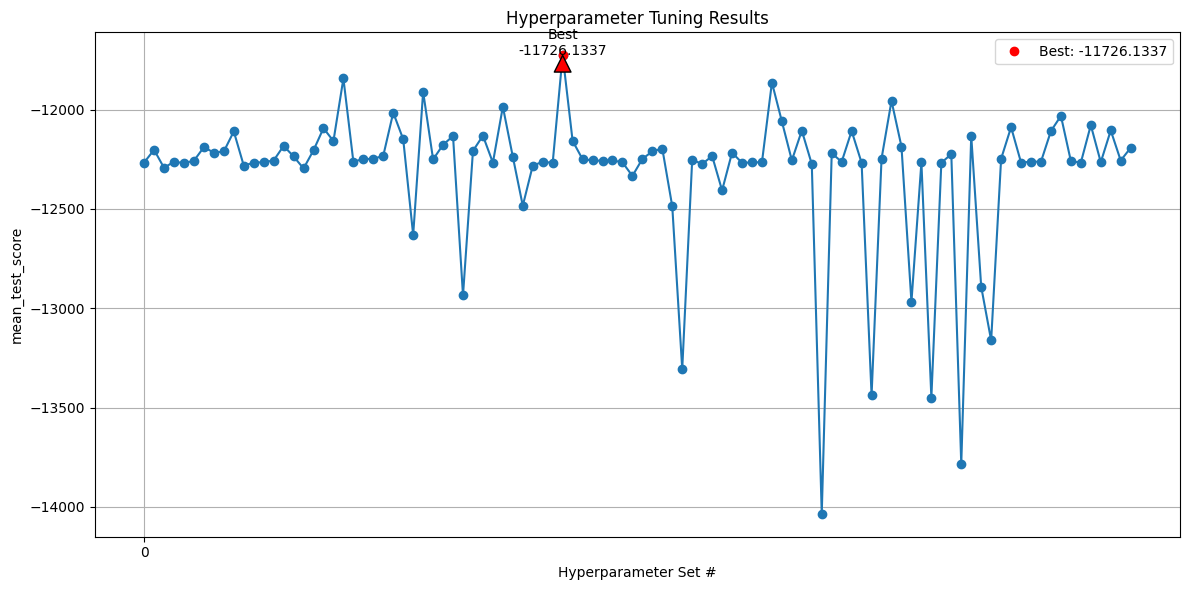

In [49]:
data = plot_hyperparam_search_results(randomized_search.cv_results_, xtick_step=100)

In [50]:
randomized_search.best_params_

{'RandomForestRegressor__bootstrap': False,
 'RandomForestRegressor__max_depth': None,
 'RandomForestRegressor__max_features': 'sqrt',
 'RandomForestRegressor__min_samples_leaf': 3,
 'RandomForestRegressor__min_samples_split': 7,
 'RandomForestRegressor__n_estimators': 229}

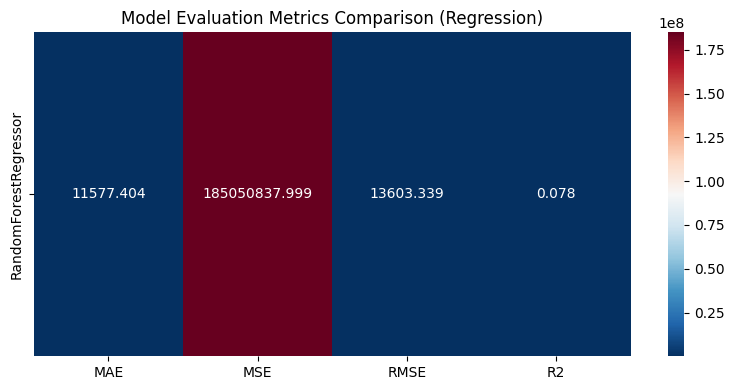

In [51]:
randomized_search_metrics = train_evaluate_models(
    models=[('RandomForestRegressor', randomized_search.best_estimator_)],
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    seed=SEED
)

In [52]:
randomized_search_metrics

,MAE,MSE,RMSE,R2
RandomForestRegressor,11577.404237,1.850508e+08,13603.339222,0.078092


(<Figure size 800x400 with 2 Axes>,
                              MAE       RMSE        R2
 RandomForestRegressor  44.878144 -23.933244  0.003247)

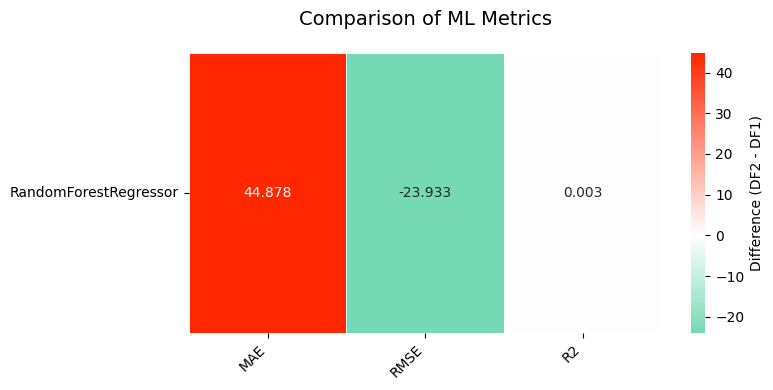

In [53]:
compare_metrics_heatmap(initial_metrics, randomized_search_metrics)

### 2.3 Bayes Search

In [54]:
param_bayes = {
    # количество деревьев
    "RandomForestRegressor__n_estimators": Integer(100, 600),

    # максимальная глубина дерева
    "RandomForestRegressor__max_depth": Integer(3, 20),

    # минимальное число объектов для сплита
    "RandomForestRegressor__min_samples_split": Integer(2, 10),

    # минимальное число объектов в листе
    "RandomForestRegressor__min_samples_leaf": Integer(1, 10),

    # доля признаков для выбора лучшего разбиения
    "RandomForestRegressor__max_features": Categorical(["sqrt", "log2", 0.5, 1.0]),

    # использовать ли бутстрэп
    "RandomForestRegressor__bootstrap": Categorical([True, False]),
}

In [57]:
bayes_search = BayesSearchCV(
    random_state=SEED,
    estimator=pipeline,
    search_spaces=param_bayes,
    n_iter=100, 
    cv=cv,      
    scoring='neg_mean_absolute_error',  
    optimizer_kwargs={'base_estimator': 'GP'}, 
    verbose=3,
    n_jobs=-1 
)

In [58]:
bayes_search_start = timer()
bayes_search.fit(X_train, y_train)
bayes_search_end = timer()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(20), np.str_('log2'), np.int64(1), np.int64(2), np.int64(600)] before, using random point [False, np.int64(10), 'log2', np.int64(2), np.int64(10), np.int64(170)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(20), np.str_('log2'), np.int64(1), np.int64(2), np.int64(600)] before, using random point [True, np.int64(4), 'log2', np.int64(8), np.int64(9), np.int64(268)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(20), np.str_('log2'), np.int64(1), np.int64(2), np.int64(600)] before, using random point [False, np.int64(9), 'log2', np.int64(6), np.int64(8), np.int64(171)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(20), np.str_('log2'), np.int64(1), np.int64(2), np.int64(600)] before, using random point [True, np.int64(10), 1.0, np.int64(6), np.int64(3), np.int64(316)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(20), np.str_('log2'), np.int64(1), np.int64(2), np.int64(600)] before, using random point [False, np.int64(17), 0.5, np.int64(9), np.int64(6), np.int64(297)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(20), np.str_('log2'), np.int64(1), np.int64(2), np.int64(600)] before, using random point [False, np.int64(8), 'sqrt', np.int64(9), np.int64(4), np.int64(433)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(20), np.str_('log2'), np.int64(1), np.int64(2), np.int64(600)] before, using random point [False, np.int64(5), 1.0, np.int64(3), np.int64(8), np.int64(319)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(20), np.str_('log2'), np.int64(1), np.int64(2), np.int64(600)] before, using random point [True, np.int64(11), 1.0, np.int64(10), np.int64(4), np.int64(121)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(20), np.str_('log2'), np.int64(1), np.int64(2), np.int64(600)] before, using random point [True, np.int64(13), 'sqrt', np.int64(3), np.int64(10), np.int64(531)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(20), np.str_('log2'), np.int64(1), np.int64(2), np.int64(600)] before, using random point [False, np.int64(9), 'sqrt', np.int64(5), np.int64(2), np.int64(381)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(20), np.str_('log2'), np.int64(1), np.int64(2), np.int64(600)] before, using random point [False, np.int64(8), 'sqrt', np.int64(7), np.int64(7), np.int64(488)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(20), np.str_('log2'), np.int64(1), np.int64(2), np.int64(600)] before, using random point [True, np.int64(18), 'log2', np.int64(6), np.int64(2), np.int64(148)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(20), np.str_('log2'), np.int64(1), np.int64(2), np.int64(600)] before, using random point [False, np.int64(16), 1.0, np.int64(1), np.int64(10), np.int64(200)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(20), np.str_('log2'), np.int64(1), np.int64(2), np.int64(600)] before, using random point [True, np.int64(18), 1.0, np.int64(8), np.int64(7), np.int64(491)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(20), np.str_('log2'), np.int64(1), np.int64(2), np.int64(600)] before, using random point [True, np.int64(6), 1.0, np.int64(2), np.int64(6), np.int64(357)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(20), np.str_('log2'), np.int64(1), np.int64(2), np.int64(600)] before, using random point [False, np.int64(16), 1.0, np.int64(8), np.int64(3), np.int64(555)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(20), np.str_('log2'), np.int64(1), np.int64(2), np.int64(600)] before, using random point [False, np.int64(13), 1.0, np.int64(7), np.int64(3), np.int64(330)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(20), np.str_('log2'), np.int64(1), np.int64(2), np.int64(600)] before, using random point [False, np.int64(11), 1.0, np.int64(7), np.int64(3), np.int64(414)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(20), np.str_('log2'), np.int64(1), np.int64(2), np.int64(600)] before, using random point [True, np.int64(4), 1.0, np.int64(1), np.int64(10), np.int64(449)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(20), np.str_('log2'), np.int64(1), np.int64(2), np.int64(600)] before, using random point [False, np.int64(17), 'log2', np.int64(5), np.int64(7), np.int64(498)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(20), np.str_('log2'), np.int64(1), np.int64(2), np.int64(600)] before, using random point [True, np.int64(14), 0.5, np.int64(4), np.int64(3), np.int64(411)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(20), np.str_('log2'), np.int64(1), np.int64(2), np.int64(600)] before, using random point [False, np.int64(13), 'log2', np.int64(3), np.int64(7), np.int64(240)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(20), np.str_('log2'), np.int64(1), np.int64(2), np.int64(600)] before, using random point [True, np.int64(14), 'sqrt', np.int64(7), np.int64(7), np.int64(393)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(20), np.str_('log2'), np.int64(1), np.int64(2), np.int64(600)] before, using random point [True, np.int64(4), 0.5, np.int64(5), np.int64(6), np.int64(261)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(20), np.str_('sqrt'), np.int64(1), np.int64(2), np.int64(600)] before, using random point [True, np.int64(6), 'log2', np.int64(2), np.int64(4), np.int64(588)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [59]:
print(f"Total time: {bayes_search_end - bayes_search_start:.2f} seconds")

Total time: 2998.47 seconds


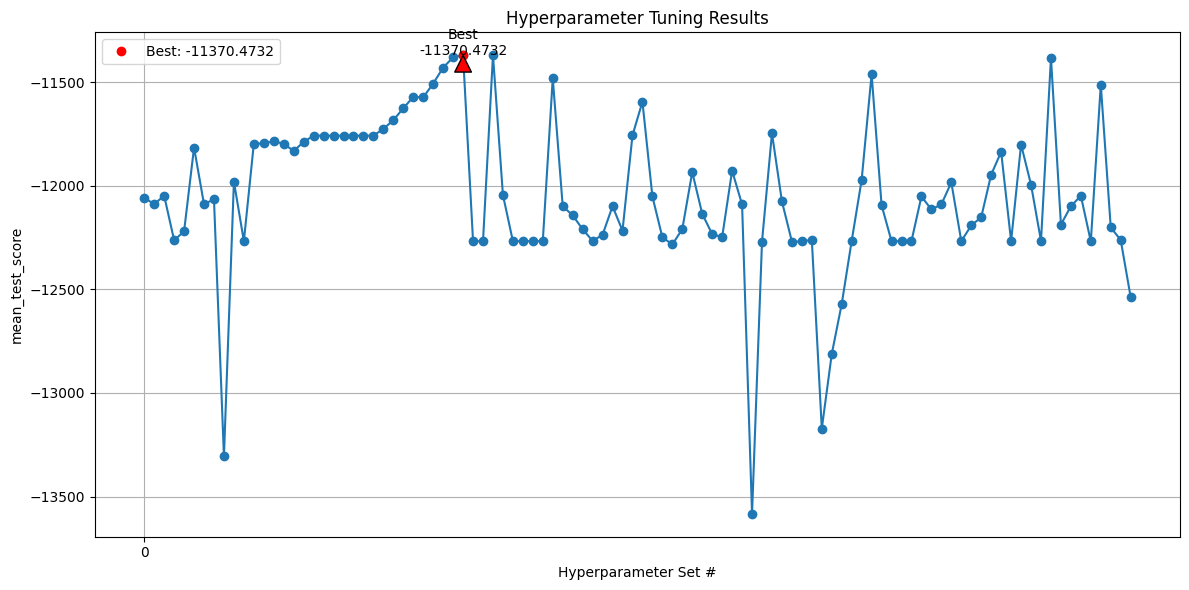

In [60]:
data = plot_hyperparam_search_results(bayes_search.cv_results_, xtick_step=100)

In [61]:
bayes_search.best_params_

OrderedDict([('RandomForestRegressor__bootstrap', False),
             ('RandomForestRegressor__max_depth', 20),
             ('RandomForestRegressor__max_features', 'sqrt'),
             ('RandomForestRegressor__min_samples_leaf', 1),
             ('RandomForestRegressor__min_samples_split', 2),
             ('RandomForestRegressor__n_estimators', 600)])

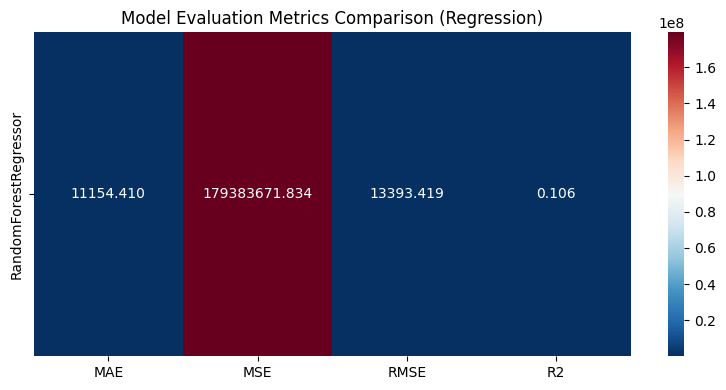

In [62]:
bayes_search_metrics = train_evaluate_models(
    models=[('RandomForestRegressor', bayes_search.best_estimator_)],
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    seed=SEED
)

In [63]:
bayes_search_metrics

,MAE,MSE,RMSE,R2
RandomForestRegressor,11154.41016,1.793837e+08,13393.418975,0.106325


(<Figure size 800x400 with 2 Axes>,
                               MAE        RMSE       R2
 RandomForestRegressor -378.115934 -233.853492  0.03148)

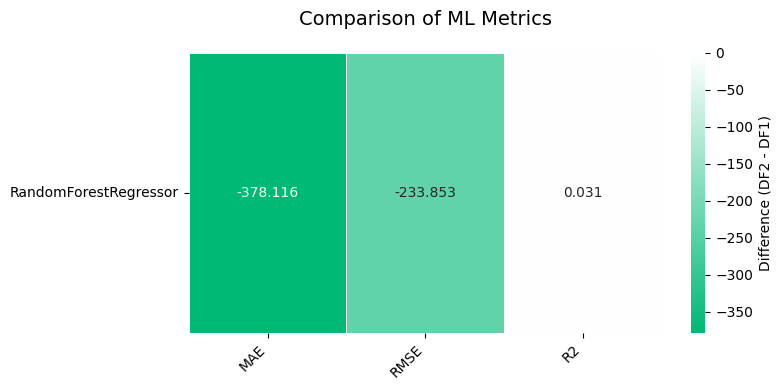

In [64]:
compare_metrics_heatmap(initial_metrics, bayes_search_metrics)

(<Figure size 800x400 with 2 Axes>,
                               MAE        RMSE        R2
 RandomForestRegressor  422.994078  209.920248 -0.028233)

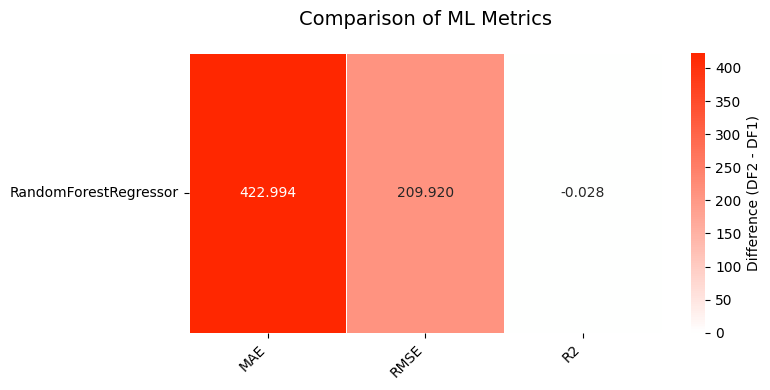

In [66]:
compare_metrics_heatmap(bayes_search_metrics, randomized_search_metrics)